In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import ipywidgets
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import datetime

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

# SkLearn
from sklearn.metrics import accuracy_score, precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#Torch Viz
from torchviz import make_dot

tqdm.pandas()

C:\Users\Project Apollo\AppData\Roaming\Python\Python38\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
class FlowsData(Dataset):
    def __init__(self,binary=True):
        self.binary = binary
        
        print('Opening Files...')
        start = time.perf_counter()
        mssql_path = "Data/MSSQL_sort.csv"
        udp_path = "Data/UDP_sort.csv"
        ldap_path = "Data/LDAP_sort.csv"
        portmap_path = "Data/Portmap_sort.csv"
        netbios_path = "Data/NetBIOS_sort.csv"
        bening_path = "Data/BENIGN_sort.csv"
        
        mssql = self.getcsv(mssql_path)
        udp = self.getcsv(udp_path)
        ldap = self.getcsv(ldap_path)
        portmap = self.getcsv(portmap_path)
        netbios = self.getcsv(netbios_path)
        benign = self.getcsv(bening_path)
        
        print('Sampling Data...')
        self.min_length = min(len(mssql),min(len(udp),len(benign)))
        
        split = 6 if binary else 1
        
        self.mssql = mssql.sample(n=round(self.min_length/split)).reset_index(drop=True).to_numpy()
        self.udp = udp.sample(n=round(self.min_length/split)).reset_index(drop=True).to_numpy()
        self.ldap = ldap.sample(n=round(self.min_length/split)).reset_index(drop=True).to_numpy()
        self.netbios = netbios.sample(n=round(self.min_length/split)).reset_index(drop=True).to_numpy()
        self.portmap = portmap.sample(n=round(self.min_length/split)).reset_index(drop=True).to_numpy()

        self.benign = benign.sample(n=self.min_length).reset_index(drop=True).to_numpy()
        stop = time.perf_counter()
        print('Preparing Data...')
        self.prepare()
        
        print(f'That took {stop-start:.3f}')
        
    def prepare(self):
        
        dataset = np.concatenate((self.mssql,self.udp,self.ldap,self.netbios,self.portmap,self.benign), axis=0)
        np.random.shuffle(dataset)
        dataset_labels = dataset[:,7]
        dataset=np.delete(dataset,7,axis=1)
        dataset=normalize(dataset)
        dataset=dataset.reshape((len(dataset),3,3))
        
        if self.binary:
            dataset_labels[dataset_labels != 'BENIGN'] = 1
        else:
            dataset_labels[dataset_labels == 'MSSQL'] = 1
            dataset_labels[dataset_labels == 'UDP'] = 2
            dataset_labels[dataset_labels == 'LDAP'] = 3
            dataset_labels[dataset_labels == 'NetBIOS'] = 4
            dataset_labels[dataset_labels == 'Portmap'] = 5
        
        dataset_labels[dataset_labels == 'BENIGN'] = 0
        
        self.data={'data':dataset,'labels':dataset_labels}
        
        
            
            
    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self,idx=None):
        if torch.is_tensor(idx):
            idx.tolist()
            
        if idx == None:
            sample = {'data':self.data['data'][:], 'labels':self.data['labels'][:]}
        else:
            sample = {'data':self.data['data'][idx], 'labels':self.data['labels'][idx]}
        
        return sample['data'],sample['labels']
    
    def getcsv(self, path):
        return pd.read_csv(path, low_memory=False)

In [3]:
class ActiveSet(Dataset):
    def __init__(self,data,labels):
        self.x = data
        self.y = labels
        
    def __getitem__(self,index):
        return (self.x[index],self.y[index])
    
    def __len__(self):
        return len(self.x)

In [4]:
class Net(Module):
    def __init__(self, binary=True):
        super(Net, self).__init__()
        self.run = False
        self.binary = binary
        self.cnn_layers = Sequential(
            Conv2d(1,4,kernel_size=2,stride=1,padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=1),
            Conv2d(4,4,kernel_size=2,stride=1,padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=1)
        )
        
        if self.binary:
            self.linear_layers = Sequential(
                Linear(36,36),
                ReLU(inplace=True),
                Linear(36,2)
            )
        else:
            self.linear_layers = Sequential(
                Linear(36,36),
                ReLU(inplace=True),
                Linear(36,6)
            )
        
    def forward(self, x):
        if not self.run: print(f'Input: {x.shape}')
        x=x.float()
        if not self.run: print(x.shape)
        x = self.cnn_layers(x)
        if not self.run: print(f'CNN:Layers: {x.shape}')
        x = x.view(x.size(0),-1)
        if not self.run: print(x.shape)
        x = self.linear_layers(x)
        if not self.run: print(f'Linear: {x.shape}')
            
        if not self.run: self.run = True
        return x

In [5]:
class Trainer():
    def __init__(self, model=None, optimizer = None, criterion = None, 
                 dataset = None, batchsize = 512, lr = 0.01, binary = True, test_percent = 0.3, save=False, verbose = True):
        
        self.verbose = verbose
        bold = '\033[1m'
        if self.verbose:
            print("\n==================\nInitilizing System\n==================")
            print(f'{bold}Hyper Parameters\033[0m:\nModel: {model}\
            \nOptimizer: {optimizer}\
            \nCriterion: {criterion}\
            \nDataset: {dataset}\
            \nBatch size: {batchsize}\
            \nLearning rate: {lr}\
            \nBinary classification: {binary}\
            \nTest ratio: {test_percent}\
            \nSave untrained model: {save}\n')
        # Static variables           
        self.binary = binary
        self.batchsize = batchsize
        self.test_percent = test_percent
        self.save = save
        
        # Variables concerning the model
        if self.verbose:
            print('Preparing Model')
        self.model = model if model else Net(binary)
        self.optimizer = optimizer if optimizer else Adam(self.model.parameters(),lr=lr)
        self.criterion = criterion if criterion else CrossEntropyLoss()
        
        # Dataset
        if self.verbose:
            print('Loading Dataset')
        self.dataset = dataset if dataset else FlowsData(binary=self.binary)
        
        # Preparing the data
        self.prepare_data()
        
        # Moving the model to the GPU if available
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            self.criterion = self.criterion.cuda()
        

        print("\n==================\nModel\n==================\n{}\n".format(self.model))
        
        # Display model info
        if self.verbose:
            self.model_info()
            
        # Save model
        if self.save:
            if self.verbose:
                print("Saving Model")
            self.save_model(self.binary)
        
    def save_model(self, binary = False,trained=False, PATH = "Models/"):
        filename = "model-"
        if binary:
            filename += "binary-"
        if trained:
            filename += "trained-"
        
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y %H-%M-%S")
        
        filename+= dt_string
        filename+= ".pt"
        
        PATH+=filename
        
        try:
            torch.save(self.model.state_dict(),PATH)
            print(f'Model Saved {PATH}')
        except Exception as e:
            print("ERROR:There was an issue saving the model!")
            print(e)
        
    def load_model(self, model_name,PATH = "Models/"):
        PATH+=model_name
            
        try:
            self.model.load_state_dict(torch.load(PATH))
            self.model.eval()
            print(f'Model: {model_name} successfully loaded\n')
            print(self.model)
        except Exception as e:
            print("ERROR:There was an issue loading the model!\nUsing default model!")
            print(e)
            
            
    
    def model_info(self):
        # Print model's state_dict
        print("\nModel's state_dict:")
        for param_tensor in self.model.state_dict():
            print(param_tensor, "\t", self.model.state_dict()[param_tensor].size())

        # Print optimizer's state_dict
        print("\nOptimizer's state_dict:")
        for var_name in self.optimizer.state_dict():
            print(var_name, "\t", self.optimizer.state_dict()[var_name])
    
    def prepare_data(self):
        x,y=self.dataset.__getitem__()
        train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=self.test_percent)
        print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))
        
        # Training Set
        train_x = train_x.reshape(len(train_x),1,3,3)
        self.train_x = torch.from_numpy(train_x)

        train_y = train_y.astype(int)
        self.train_y=torch.from_numpy(train_y)

        print(self.train_x.shape,self.train_y.shape)
        
        # Validation Set
        val_x = val_x.reshape(len(val_x), 1, 3, 3)
        self.val_x = torch.from_numpy(val_x)

        val_y = val_y.astype(int)
        self.val_y=torch.from_numpy(val_y)

        print(self.val_x.shape,self.val_y.shape)
        
        # Add to dataloader
        self.train_set = DataLoader(ActiveSet(self.train_x,self.train_y),batch_size=self.batchsize,shuffle=True)
        self.val_set = DataLoader(ActiveSet(self.val_x,self.val_y),batch_size=self.batchsize,shuffle=True)
        
        print("Data ready!")
    
    def train(self, n_epochs = 500, verbose=False):
        train_losses = []
        val_losses = []
        val_accuracies = []
        train_accuracies = []
        
        for epoch in tqdm(range(n_epochs)):
            train_losses, val_losses, val_accuracies, train_accuracies = self.trainer(epoch, train_losses, 
                                                                                      val_losses,val_accuracies,
                                                                                      train_accuracies,verbose)
        plt.plot(train_losses,label='Training loss')
        plt.plot(val_losses,label='Validation loss')
        plt.legend()
        plt.show()
        
        plt.plot(train_accuracies,label='Training accuracy')
        plt.plot(val_accuracies,label='Validation accuracy')
        plt.legend()
        plt.show()
        self.save_model(binary=self.binary,trained=True)
        return self.model
            
    def trainer(self,epoch,train_losses,val_losses,val_accuracies,train_accuracies,verbose):
        start = time.perf_counter()
        self.model.train()
        tr_loss = 0
    
        epoch_train_losses = []
        epoch_val_losses = []
    
        for x_batch,y_batch in self.train_set:
            x_train,y_train = Variable(x_batch),Variable(y_batch)
            if torch.cuda.is_available():
                x_train = x_train.cuda()
                y_train = y_train.cuda()
        
            output_train = self.model(x_train)
        
            loss_train = self.criterion(output_train,y_train.long())
            tr_loss = loss_train.item()
            epoch_train_losses.append(loss_train.data.cpu().numpy())
            loss_train.backward()
        
        for x_batch,y_batch in self.val_set:
            x_val,y_val = Variable(x_batch),Variable(y_batch)
            if torch.cuda.is_available():
                x_val = x_val.cuda()
                y_val = y_val.cuda()
        
            output_val = self.model(x_val)
        
            loss_val = self.criterion(output_val,y_val.long())
            epoch_val_losses.append(loss_val.data.cpu().numpy())
        
        
        train_losses.append(np.average(epoch_train_losses))
        val_losses.append(np.average(epoch_val_losses))
        self.optimizer.step()
        self.optimizer.zero_grad()
        stop = time.perf_counter()
        
        with torch.no_grad():
            output=self.model(self.train_x.cuda())
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob,axis=1)
        train_accuracies.append(accuracy_score(self.train_y,predictions))
        
        with torch.no_grad():
            output=self.model(self.val_x.cuda())
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob,axis=1)
        val_accuracies.append(accuracy_score(self.val_y,predictions))
        
        if epoch%50 == 0 and verbose:
            print("Epoch:{}\t loss:{}\t ".format(epoch,tr_loss))
        return train_losses, val_losses,val_accuracies,train_accuracies
    
    def eval_results(self):
        # Eval results on train
        with torch.no_grad():
            output=self.model(self.train_x.cuda())
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob,axis=1)
        train_accuracy = accuracy_score(self.train_y,predictions)
        
        train_precision = precision_score(self.train_y.data.cpu().numpy(),np.array(predictions),average='weighted')
        train_recall = recall_score(self.train_y.data.cpu().numpy(),np.array(predictions),average='weighted')
        train_f1 = f1_score(self.train_y.data.cpu().numpy(),np.array(predictions), average='weighted')
        if self.binary:
            train_confusion = ConfusionMatrixDisplay(confusion_matrix(self.train_y.data.cpu().numpy(), 
                                                                  np.array(predictions)),display_labels=['Benign','Attack'])
        else:
            train_confusion = ConfusionMatrixDisplay(confusion_matrix(self.train_y.data.cpu().numpy(),
                                                                      np.array(predictions)),
                                                     display_labels=['Benign','MSSQL','UDP','LDAP','NetBIOS','Portmap'])
        
        with torch.no_grad():
            output=self.model(self.val_x.cuda())
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob,axis=1)
        test_accuracy = accuracy_score(self.val_y,predictions)
        
        test_precision = precision_score(self.val_y.data.cpu().numpy(),np.array(predictions),average='weighted')
        test_recall = recall_score(self.val_y.data.cpu().numpy(),np.array(predictions),average='weighted')
        test_f1 = f1_score(self.val_y,np.array(predictions), average='weighted')
        if self.binary:
            test_confusion = ConfusionMatrixDisplay(confusion_matrix(self.val_y.data.cpu().numpy(), 
                                                                 np.array(predictions)),display_labels=['Benign','Attack'])
        else:
            test_confusion = ConfusionMatrixDisplay(confusion_matrix(self.val_y.data.cpu().numpy(), 
                                                                 np.array(predictions)),
                                                    display_labels=['Benign','MSSQL','UDP','LDAP','NetBIOS','Portmap'])
        
        results = np.array([[train_accuracy,train_precision,train_recall,train_f1],
                           [test_accuracy,test_precision,test_recall,test_f1]])
        results = pd.DataFrame(data=results, index=["Train", "Evaluation"], columns=["Accuracy", "Precision","Recall","f1"])
        display(results)
        
        print("(Top) Training Confusion Matrix")
        train_confusion.plot()
        print("(Bottom) Evaluation Confusion Matrix")
        test_confusion.plot()
        
        


Initilizing System
Hyper Parameters:
Model: None            
Optimizer: None            
Criterion: None            
Dataset: None            
Batch size: 512            
Learning rate: 0.01            
Binary classification: True            
Test ratio: 0.3            
Save untrained model: False

Preparing Model
Loading Dataset
Opening Files...
Sampling Data...
Preparing Data...
That took 11.959
((21953, 3, 3), (21953,)) ((9409, 3, 3), (9409,))
torch.Size([21953, 1, 3, 3]) torch.Size([21953])
torch.Size([9409, 1, 3, 3]) torch.Size([9409])
Data ready!

Model
Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affin

Input: torch.Size([512, 1, 3, 3])
torch.Size([512, 1, 3, 3])
CNN:Layers: torch.Size([512, 4, 3, 3])
torch.Size([512, 36])
Linear: torch.Size([512, 2])



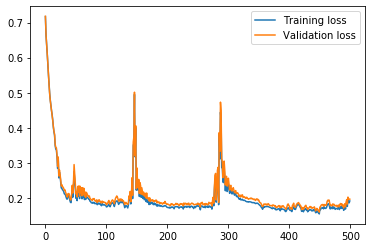

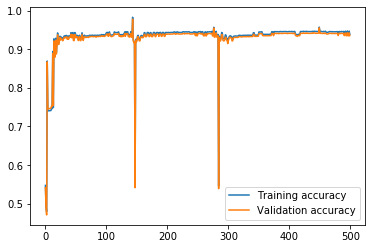

Model Saved Models/model-binary-trained-30-12-2020 13-07-04.pt


Accuracy  Precision    Recall        f1
Train       0.938778   0.945866  0.938778  0.938905
Evaluation  0.935275   0.943126  0.935275  0.935351

(Top) Training Confusion Matrix
(Bottom) Evaluation Confusion Matrix


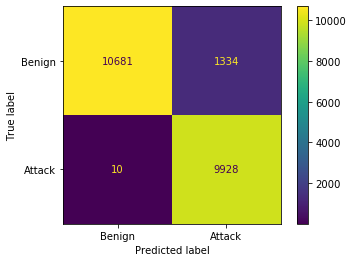

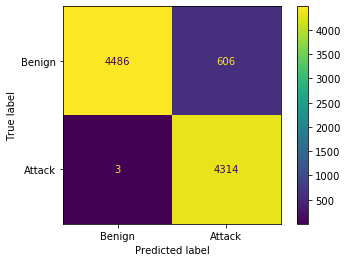

In [6]:
run_binary = Trainer()
trained_binary = run_binary.train()
run_binary.eval_results()


Initilizing System
Hyper Parameters:
Model: None            
Optimizer: None            
Criterion: None            
Dataset: None            
Batch size: 512            
Learning rate: 0.01            
Binary classification: False            
Test ratio: 0.3            
Save untrained model: False

Preparing Model
Loading Dataset
Opening Files...
Sampling Data...
Preparing Data...
That took 11.878
((71849, 3, 3), (71849,)) ((30793, 3, 3), (30793,))
torch.Size([71849, 1, 3, 3]) torch.Size([71849])
torch.Size([30793, 1, 3, 3]) torch.Size([30793])
Data ready!

Model
Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, 

Input: torch.Size([512, 1, 3, 3])
torch.Size([512, 1, 3, 3])
CNN:Layers: torch.Size([512, 4, 3, 3])
torch.Size([512, 36])
Linear: torch.Size([512, 6])



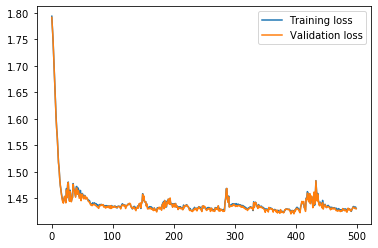

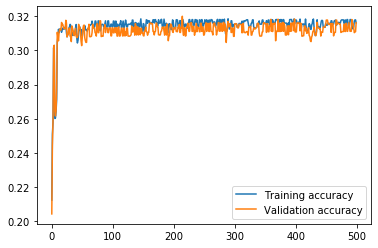

Model Saved Models/model-trained-30-12-2020 13-15-23.pt


C:\Users\Project Apollo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy  Precision    Recall        f1
Train       0.316107   0.198554  0.316107  0.211921
Evaluation  0.316208   0.199148  0.316208  0.212262

(Top) Training Confusion Matrix
(Bottom) Evaluation Confusion Matrix


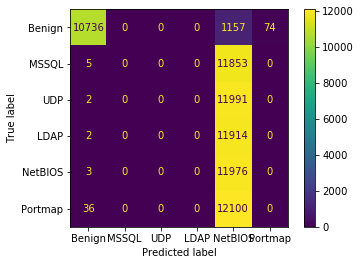

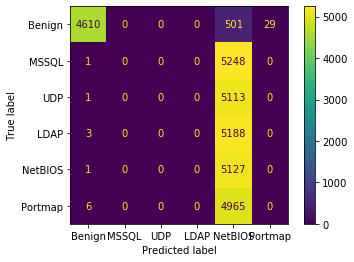

In [7]:
run_multi = Trainer(binary=False)
trained_multi =run_multi.train()
run_multi.eval_results()